# Node Class Demo - M2M Sleep-Based Simulator

**Author:** [Removed]  
**Date:** February 10, 2026  
**Task:** 1.1 - Node Class Implementation

This notebook demonstrates the functionality of the MTD Node class, which implements sleep-based random access with slotted Aloha.

In [11]:
# Add project root to path so "from src..." works from any working directory
import os
import sys
import subprocess

_path = os.path.abspath(os.getcwd())
for _ in range(10):
    if os.path.isdir(os.path.join(_path, "src")) and os.path.exists(os.path.join(_path, "requirements.txt")):
        break
    _path = os.path.dirname(_path)
else:
    _path = os.path.abspath(os.path.join(os.getcwd(), ".."))
if _path not in sys.path:
    sys.path.insert(0, _path)

# Ensure dependencies are installed in this kernel's Python (fixes ModuleNotFoundError after clone)
def _ensure_deps():
    try:
        import matplotlib  # noqa: F401
        import numpy  # noqa: F401
    except ImportError:
        req = os.path.join(_path, "requirements.txt")
        print("Installing dependencies into this Python...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "-r", req])
        print("Done. Re-run this cell.")

_ensure_deps()

from src.node import Node, NodeState
import random
import matplotlib.pyplot as plt
import numpy as np

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("Modules imported successfully!")

Installing dependencies into this Python...
Done. Re-run this cell.
Modules imported successfully!


## 1. Node Initialization

Create a node with 3GPP-inspired power values.

In [12]:
# Configure power rates (3GPP NR inspired)
power_rates = {
    'PT': 10.0,   # Transmit power (highest)
    'PB': 5.0,    # Busy/collision power
    'PI': 1.0,    # Idle power
    'PW': 2.0,    # Wake-up power
    'PS': 0.1     # Sleep power (lowest)
}

# Create a node
node = Node(
    node_id=1,
    initial_energy=1000.0,
    idle_timer=10,        # ts parameter (slots before sleep)
    wakeup_time=5,        # tw parameter (slots to wake up)
    power_rates=power_rates
)

print(f"Node created: {node}")
print(f"Initial state: {node.state.value}")
print(f"Initial energy: {node.energy:.2f} units")

Node created: Node(id=1, state=idle, queue_len=0, energy=1000.00)
Initial state: idle
Initial energy: 1000.00 units


## 2. Packet Arrival Simulation

Simulate packet arrivals using Bernoulli process with arrival rate λ.

In [13]:
# Simulate packet arrivals over 100 slots
arrival_rate = 0.1  # λ = 0.1 (10% chance per slot)
arrivals = []

for slot in range(100):
    arrived = node.arrive_packet(slot, arrival_rate)
    if arrived:
        arrivals.append(slot)

print(f"Packets arrived: {len(arrivals)}")
print(f"Arrival slots: {arrivals[:10]}...")  # Show first 10
print(f"Node state after arrivals: {node.state.value}")
print(f"Queue length: {node.get_queue_length()}")

Packets arrived: 13
Arrival slots: [1, 7, 9, 12, 19, 26, 27, 41, 44, 67]...
Node state after arrivals: active
Queue length: 13


## 3. State Transitions Demo

Demonstrate state transitions: IDLE → ACTIVE → IDLE → SLEEP → WAKEUP → ACTIVE

Slot 0: Packet arrived → active
Slot 2: Transmission successful → queue empty
Slot 6: Node state = sleep
Slot 8: Packet during sleep → wakeup
Slot 11: Wake-up complete → active


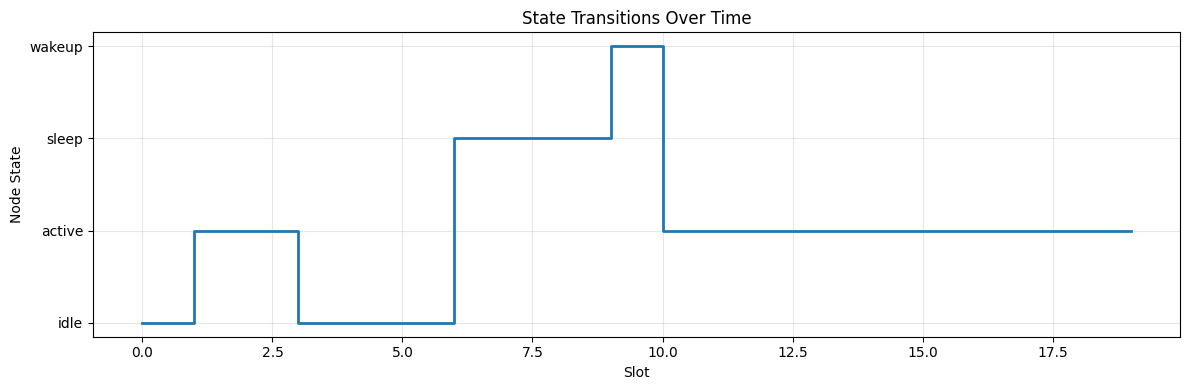

In [14]:
# Create a fresh node for state transition demo
demo_node = Node(1, 1000.0, idle_timer=3, wakeup_time=2, power_rates=power_rates)

states = []
slots = []

# Track state over time
for slot in range(20):
    # Record state
    states.append(demo_node.state.value)
    slots.append(slot)
    
    # Simulate events
    if slot == 0:
        # Packet arrives at slot 0
        demo_node.arrive_packet(slot, 1.0)
        print(f"Slot {slot}: Packet arrived → {demo_node.state.value}")
    elif slot == 2:
        # Successful transmission
        demo_node.handle_success(slot)
        print(f"Slot {slot}: Transmission successful → queue empty")
    elif slot == 6:
        # After idle_timer expires, should be in sleep
        print(f"Slot {slot}: Node state = {demo_node.state.value}")
    elif slot == 8:
        # Packet arrives during sleep
        demo_node.arrive_packet(slot, 1.0)
        print(f"Slot {slot}: Packet during sleep → {demo_node.state.value}")
    elif slot == 11:
        # Wake-up should be complete
        print(f"Slot {slot}: Wake-up complete → {demo_node.state.value}")
    
    # Update state
    demo_node.update_state(slot)

# Plot state transitions
state_mapping = {'idle': 0, 'active': 1, 'sleep': 2, 'wakeup': 3}
state_values = [state_mapping[s] for s in states]

plt.figure(figsize=(12, 4))
plt.step(slots, state_values, where='post', linewidth=2)
plt.yticks(list(state_mapping.values()), list(state_mapping.keys()))
plt.xlabel('Slot')
plt.ylabel('Node State')
plt.title('State Transitions Over Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

## 4. Energy Consumption Analysis

Track energy consumption in different states.

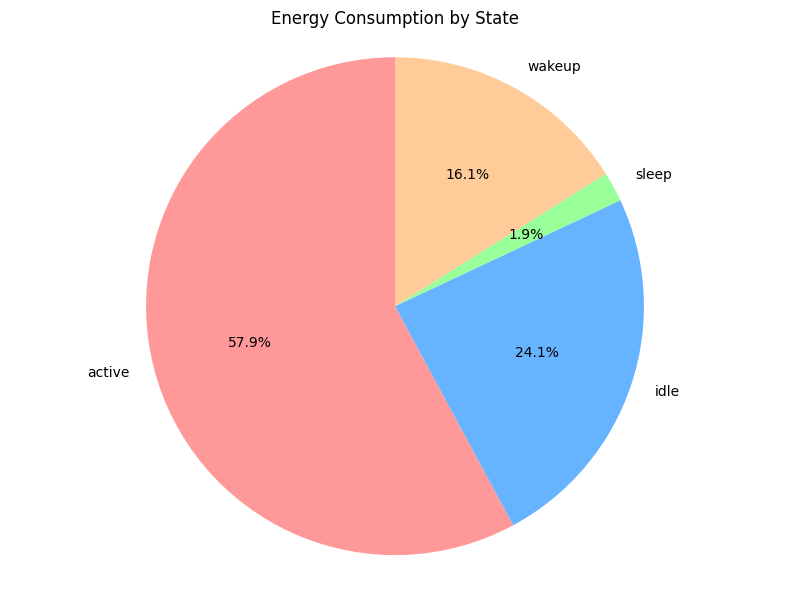


Energy Statistics:
Energy remaining: 937.80 units
Energy consumed: 62.20 units

Energy by state:
  active: 57.9%
  idle: 24.1%
  sleep: 1.9%
  wakeup: 16.1%


In [15]:
# Create node and simulate mixed activity
energy_node = Node(1, 1000.0, 10, 5, power_rates)

# Simulate 50 slots with various activities
for slot in range(50):
    # Packet arrivals
    energy_node.arrive_packet(slot, 0.05)
    
    # Transmission attempts
    transmitting = False
    if energy_node.state == NodeState.ACTIVE:
        transmitting = energy_node.attempt_transmit(0.1)
        
        # Simulate some successes
        if transmitting and random.random() < 0.5:
            energy_node.handle_success(slot)
    
    # Consume energy
    energy_node.consume_energy(was_transmitting=transmitting)
    
    # Update state
    energy_node.update_state(slot)

# Get energy breakdown
energy_fractions = energy_node.get_energy_fraction_by_state()

# Plot energy consumption pie chart
labels = [state for state in energy_fractions.keys()]
sizes = [frac for frac in energy_fractions.values()]
colors = ['#ff9999', '#66b3ff', '#99ff99', '#ffcc99']

plt.figure(figsize=(8, 6))
plt.pie(sizes, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Energy Consumption by State')
plt.axis('equal')
plt.tight_layout()
plt.show()

print(f"\nEnergy Statistics:")
print(f"Energy remaining: {energy_node.energy:.2f} units")
print(f"Energy consumed: {energy_node.initial_energy - energy_node.energy:.2f} units")
print(f"\nEnergy by state:")
for state, fraction in energy_fractions.items():
    print(f"  {state}: {fraction*100:.1f}%")

## 5. Delay Statistics

Analyze packet delays.

Delay Statistics:
Packets arrived: 9
Packets delivered: 8
Mean delay: 73.12 slots
95th percentile delay: 151.00 slots
99th percentile delay: 151.00 slots


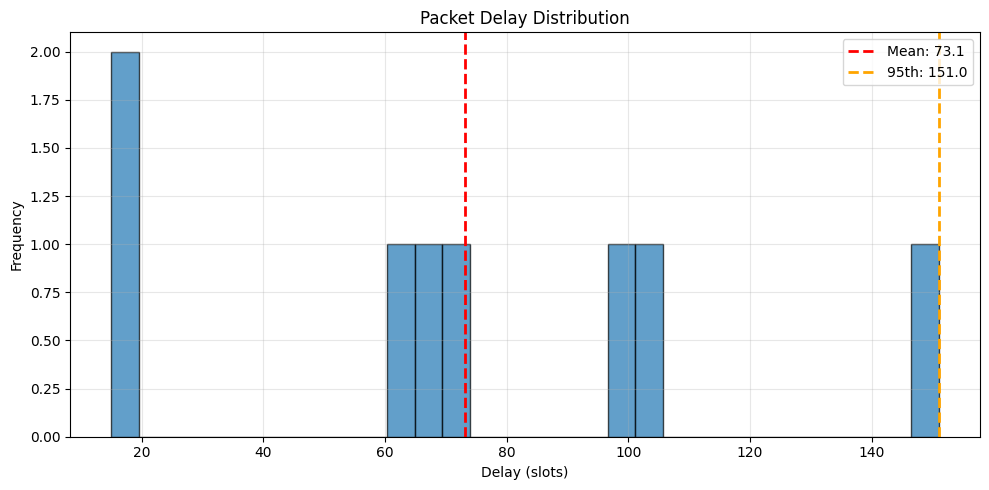

In [16]:
# Create node for delay analysis
delay_node = Node(1, 5000.0, 10, 5, power_rates)

# Simulate many slots to collect delay statistics
for slot in range(500):
    # Packet arrivals
    delay_node.arrive_packet(slot, 0.02)  # Low arrival rate
    
    # Transmission attempts
    transmitting = False
    if delay_node.state == NodeState.ACTIVE and delay_node.get_queue_length() > 0:
        transmitting = delay_node.attempt_transmit(0.05)
        
        # Simulate collision probability
        if transmitting and random.random() < 0.7:  # 70% success rate
            delay_node.handle_success(slot)
    
    # Consume energy and update
    delay_node.consume_energy(was_transmitting=transmitting)
    delay_node.update_state(slot)

# Get statistics
stats = delay_node.get_statistics(500)

print(f"Delay Statistics:")
print(f"Packets arrived: {stats['packets_arrived']}")
print(f"Packets delivered: {stats['packets_delivered']}")
print(f"Mean delay: {stats['mean_delay']:.2f} slots")
print(f"95th percentile delay: {stats['tail_delay_95']:.2f} slots")
print(f"99th percentile delay: {stats['tail_delay_99']:.2f} slots")

# Plot delay distribution
if len(delay_node.delays) > 0:
    plt.figure(figsize=(10, 5))
    plt.hist(delay_node.delays, bins=30, edgecolor='black', alpha=0.7)
    plt.axvline(stats['mean_delay'], color='r', linestyle='--', linewidth=2, label=f"Mean: {stats['mean_delay']:.1f}")
    plt.axvline(stats['tail_delay_95'], color='orange', linestyle='--', linewidth=2, label=f"95th: {stats['tail_delay_95']:.1f}")
    plt.xlabel('Delay (slots)')
    plt.ylabel('Frequency')
    plt.title('Packet Delay Distribution')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

## 6. Complete Statistics Summary

Get all node statistics.

In [17]:
# Print complete statistics
print("="*60)
print("COMPLETE NODE STATISTICS")
print("="*60)
print(f"\nNode ID: {stats['node_id']}")
print(f"\nPacket Statistics:")
print(f"  Arrived: {stats['packets_arrived']}")
print(f"  Delivered: {stats['packets_delivered']}")
print(f"  In Queue: {stats['packets_in_queue']}")
print(f"  Delivery Rate: {stats['packets_delivered']/max(stats['packets_arrived'], 1)*100:.1f}%")

print(f"\nDelay Statistics (slots):")
print(f"  Mean: {stats['mean_delay']:.2f}")
print(f"  95th percentile: {stats['tail_delay_95']:.2f}")
print(f"  99th percentile: {stats['tail_delay_99']:.2f}")

print(f"\nEnergy Statistics:")
print(f"  Remaining: {stats['energy_remaining']:.2f} units")
print(f"  Consumed: {stats['energy_consumed']:.2f} units")
print(f"  Depleted: {stats['is_depleted']}")

print(f"\nState Fractions:")
for state, fraction in stats['state_fractions'].items():
    print(f"  {state.capitalize()}: {fraction*100:.1f}%")

print(f"\nFinal State: {stats['final_state']}")
print("="*60)

COMPLETE NODE STATISTICS

Node ID: 1

Packet Statistics:
  Arrived: 9
  Delivered: 8
  In Queue: 1
  Delivery Rate: 88.9%

Delay Statistics (slots):
  Mean: 73.12
  95th percentile: 151.00
  99th percentile: 151.00

Energy Statistics:
  Remaining: 4527.30 units
  Consumed: 472.70 units
  Depleted: False

State Fractions:
  Active: 57.6%
  Idle: 6.0%
  Sleep: 33.4%
  Wakeup: 3.0%

Final State: active


## Summary

This notebook demonstrates the complete functionality of the Node class:

1. ✓ Node initialization with configurable parameters
2. ✓ Packet arrival using Bernoulli process
3. ✓ State transitions (IDLE → ACTIVE → SLEEP → WAKEUP)
4. ✓ Energy consumption tracking by state
5. ✓ Delay calculation and statistics
6. ✓ Comprehensive metrics collection

**Task 1.1 Status:** ✓ COMPLETED (Feb 10, 2026)

**Next Steps:**
- Task 1.2: Implement Simulator class (manages multiple nodes)
- Task 1.3: Integrate realistic 3GPP power model
- Task 1.4: Basic testing and debugging